In [31]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

# Antiplane slip example
In this example we will demonstrate how to use `bemcs` to compute quadratic polynomial coefficients that describe smooth slip across an arbitrary fault geometry in antiplane geometry. The steps we will follow are as follows:

1. Construct fault geometry and store it in `els`
2. Label nodes using `bemcs.label_nodes()` for open, 2-node overlapping edges and triple junctions
3. Use labelled nodes to construct an operator, $A$, to construct a matrix system: $A\cdot x = b$ where $b$ contains the boundary conditions (slip, displacement or tractions at center nodes)
4. Solve $A\cdot x = b$ to get polynomial coefficients $x$, and predict displacements and stresses everywhere in the medium

First we need to construct a fault. To do that simply provide the end points of each fault segment as follows.

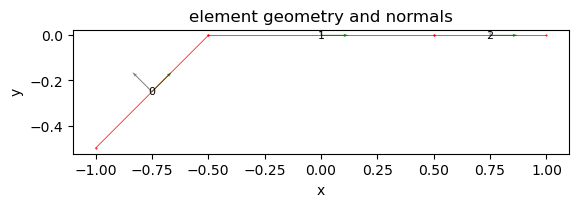

In [32]:
# Elastic parameter (shear modulus)
mu = 1.0
els = bemcs.initialize_els()

# setup a fault geometry
# triple junction
# els.x1 = np.array([-1.0, 0.0, 0.0])
# els.y1 = np.array([-0.5, 0.0, 0.0])
# els.x2 = np.array([0.0, 1.0, 0.0])
# els.y2 = np.array([0.0, -0.5, 1.0])

# non planar fault
els.x1 = np.array([-1.0, -0.5, 0.5])
els.y1 = np.array([-0.5, 0.0, 0.0])
els.x2 = np.array([-0.5, 0.5, 1.0])
els.y2 = np.array([0.0, 0.0, 0.0])

# planar fault
# els.x1 = np.array([-1, -0.5, 0.0])
# els.y1 = np.array([-0, 0.0, 0.0])
# els.x2 = np.array([-0.5, 0.0, 0.5])
# els.y2 = np.array([0.0, 0.0, 0.0])

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

## Label nodes
Identify open nodes, 2-overlap nodes and triple junctions. In this case we don't have any triple junctions, but we have two 2-overlap nodes and two open nodes. In general, for a simply connected line source with $N$ segments, we should expect $N-1$ 2-overlap nodes and two open nodes.

In [33]:
stride = 3
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = n_els  # central node equations
N_o = len(index_open)  # open node equations
N_i = 2 * len(index_overlap)  # overlapping node equations
N_t = 3 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = stride * n_els

Number of open nodes = 2
: [array([0]), array([8])]
Number of 2-overlap nodes = 2
: [array([ 3, -2]), array([ 6, -5])]
Number of triple junctions = 0
: []


## Boundary Conditions

We can deal with 3 kinds of boundary conditions
1. $s$ - slip BC
2. $t$ - $t = \hat{n}\cdot\sigma$ is a traction boundary condition
3. $u$ - displacement BC

Provide each as a list that has exactly the same length and ordering as `els`

In [34]:
# (s - slip, t - traction, u - displacement)
bc_label = ["s", "s", "s"]

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply only slip BCs at central nodes
# rhs_vec = np.array([1.0, -1.0, -1.0]) * 0.5
# fill rhs entries based on bc_label (s - slip, t - traction, u - displacement)
rhs_vec = np.array([0.5, 0.5, 0.5]) * 1


BC_c[:, 0] = rhs_vec

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

matrix_system_o, matrix_system_i, matrix_system_t = (
    bemcs.construct_smoothoperator_antiplane(
        els, index_open, index_overlap, index_triple
    )
)
# matrix_system_i[1, :] = np.array([-6, 18, -12, 0, 0, 0, 0, 0, 0]) / np.sqrt(2)

## Setup linear system of equations and solve for polynomial coefficients

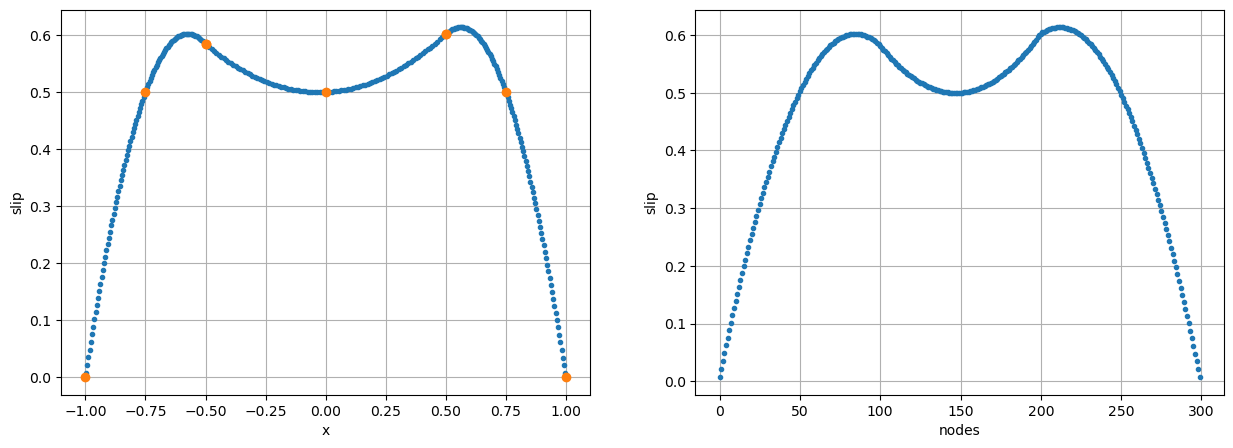

[[-1.00000000e+00  2.22044605e-16]
 [-7.50000000e-01  5.00000000e-01]
 [-5.00000000e-01  5.83571927e-01]
 [-5.00000000e-01  5.83571927e-01]
 [ 0.00000000e+00  5.00000000e-01]
 [ 5.00000000e-01  6.01825341e-01]
 [ 5.00000000e-01  6.01825341e-01]
 [ 7.50000000e-01  5.00000000e-01]
 [ 1.00000000e+00  4.51028104e-17]]


In [35]:
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient_antiplane(
    els, flag="node"
)
kernels = bemcs.get_displacement_stress_kernel_slip_antiplane(
    els.x_centers + 1e-6 * els.x_normals, els.y_centers + 1e-6 * els.y_normals, els, mu
)
t_kernels = bemcs.get_traction_kernels_antiplane(els, kernels)

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

# populate matrix_system for central nodes (check for bc_label)
for i in range(n_els):
    if bc_label[i] == "s":
        matrix_system_c[i, :] = slip_mat[stride * i + 1, :]
    elif bc_label[i] == "t":
        matrix_system_c[i, :] = t_kernels[i, :]
    elif bc_label[i] == "u":
        matrix_system_c[i, :] = kernels[2][i, :]
    else:
        ValueError("boundary condition label not recognized")

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# Solve for quadratic node coefficients
quadcoefs = np.linalg.inv(matrix_system) @ BCvector

# compute slip at nodes
xf = np.zeros(3 * n_els)
xf[0::3] = els.x1
xf[1::3] = els.x_centers
xf[2::3] = els.x2
xnodes, _, slipnodes = bemcs.get_slipvector_on_fault_antiplane(
    els, quadcoefs.flatten(), 100
)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(xnodes, slipnodes, ".")
plt.plot(xf, slip_mat @ quadcoefs, "o")
plt.xlabel("x")
plt.ylabel("slip")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(slipnodes, ".")
plt.xlabel("nodes")
plt.ylabel("slip")
plt.grid()
plt.show()
print(np.vstack((xf, slip_mat @ quadcoefs.flatten())).T)

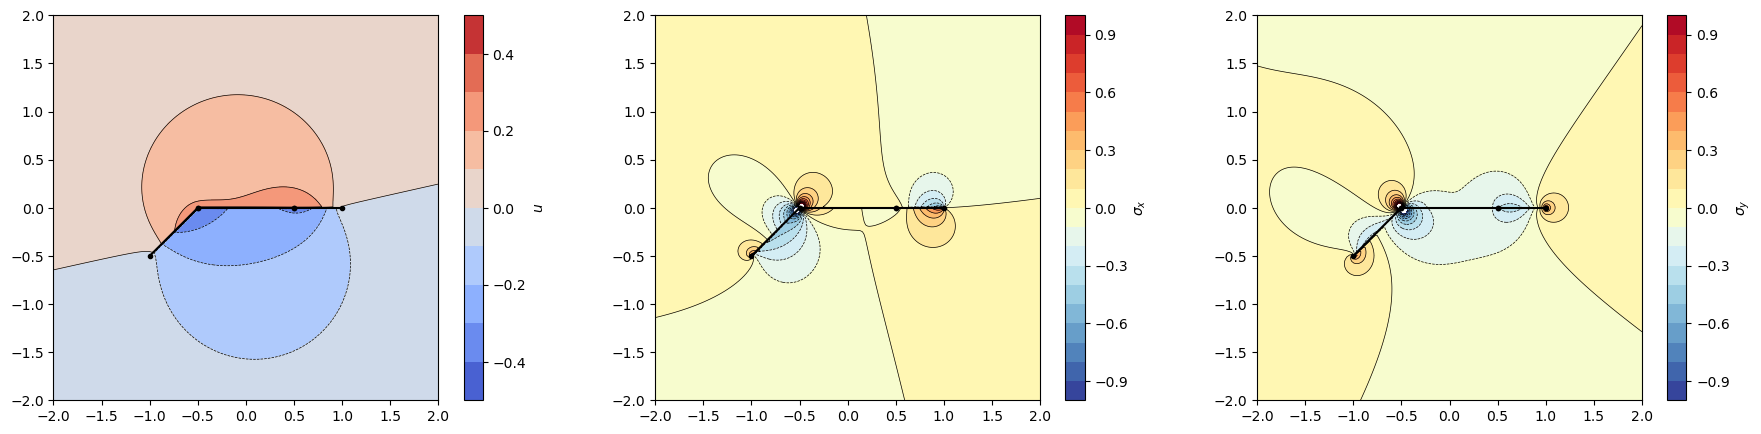

In [36]:
# # Observation points
# xo = np.linspace(-2, 2, 100).reshape(-1, 1)
# yo = np.zeros_like(xo) + 1e-6

nx_obs = 200
ny_obs = 200
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 2, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

# compute displacements and stress components
u = K_u @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 2)
toplot = sx.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="RdYlBu_r",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar(label="$\sigma_x$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
toplot = sy.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="RdYlBu_r",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar(label="$\sigma_y$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")

plt.gca().set_aspect("equal", adjustable="box")
plt.show()

## Compute tractions
Using stress kernels, we can project the stress components onto the fault normal vector to get the traction scalar: $t = \sigma \cdot \hat{n}$

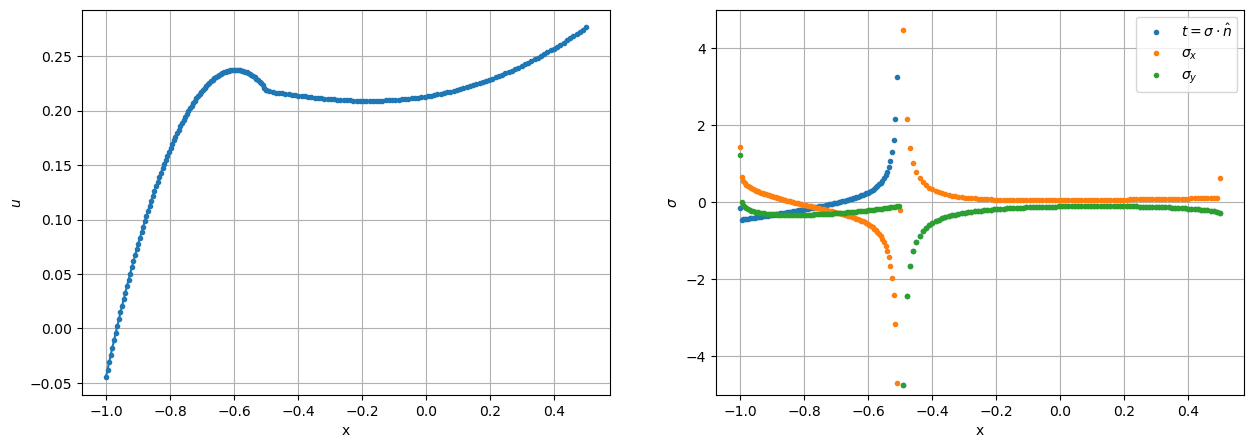

In [37]:
# Compute displacements along a line
n_pts = 100

xo = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) + 1e-6 * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) + 1e-6 * els.x_normals[1],
    )
).reshape(-1, 1)
yo = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) + 1e-6 * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) + 1e-6 * els.y_normals[1],
    )
).reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

# compute traction kernels in a specific direction
els_plot = bemcs.initialize_els()
els_plot.x_normals = np.hstack(
    (els.x_normals[0] * np.ones(n_pts), els.x_normals[1] * np.ones(n_pts))
)
els_plot.y_normals = np.hstack(
    (els.y_normals[0] * np.ones(n_pts), els.y_normals[1] * np.ones(n_pts))
)

K_t = bemcs.get_traction_kernels_antiplane(els_plot, tuple([K_sx, K_sy]), nbasis=3)
t = K_t @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(xo, K_u @ quadcoefs, ".-")
plt.xlabel("x")
plt.ylabel("$u$")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(xo, t, ".", label="$t = \sigma \cdot \hat{n}$")
plt.plot(xo, sx, ".", label="$\sigma_x$")
plt.plot(xo, sy, ".", label="$\sigma_y$")
plt.ylim((-5, 5))
plt.xlabel("x")
plt.ylabel("$\sigma$")
plt.legend()
plt.grid()
plt.show()

# Plane strain for same geometry

In [38]:
stride = 6
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junctions

# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = rhs_vec
slip_vector_y = np.zeros_like(rhs_vec)
Nequations = N_c + N_o + N_i + N_t
Nunknowns = stride * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = slip_vector_x
BC_c[1::2, 0] = slip_vector_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i))

slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = slip_mat[2::6, :]
matrix_system_c[1::2, :] = slip_mat[3::6, :]

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
coeffs = np.linalg.inv(matrix_system) @ BCvector
# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3, 0]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1), 0]

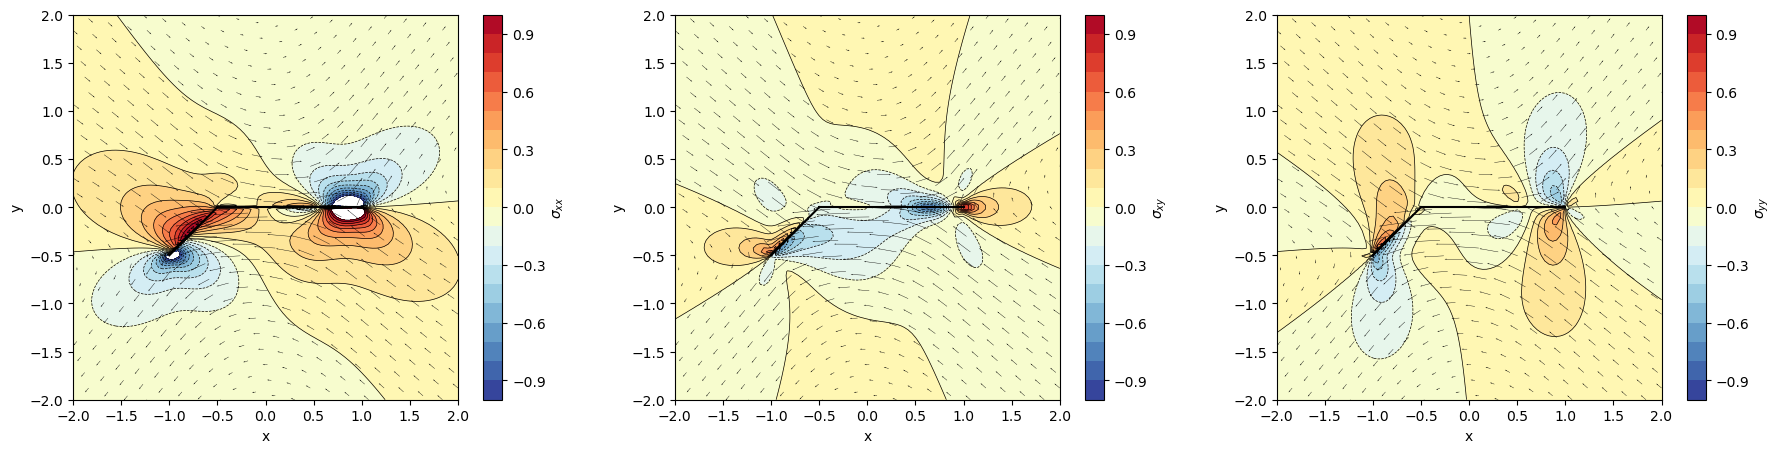

In [40]:
nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 2, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

kernels_s = bemcs.get_displacement_stress_kernel(xo, yo, els, mu, nu=0.25, flag="shear")
kernels_n = bemcs.get_displacement_stress_kernel(
    xo, yo, els, mu, nu=0.25, flag="normal"
)

# Compute displacement and stresses
u_x, u_y, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
n_skip_plot = 19
plt.figure(figsize=(22, 5))
for i in range(3):
    if i == 0:
        toplot = sxx.reshape(ny_obs, nx_obs)
        label_toplot = "$\sigma_{xx}$"
    elif i == 1:
        toplot = sxy.reshape(ny_obs, nx_obs)
        label_toplot = "$\sigma_{xy}$"
    else:
        toplot = syy.reshape(ny_obs, nx_obs)
        label_toplot = "$\sigma_{yy}$"
    plt.subplot(1, 3, i + 1)
    maxval = 1
    minval = -maxval
    img = plt.contourf(
        x_obs.reshape(ny_obs, nx_obs),
        y_obs.reshape(ny_obs, nx_obs),
        toplot,
        cmap="RdYlBu_r",
        vmin=minval,
        vmax=maxval,
        levels=np.linspace(minval, maxval, 21),
    )
    plt.contour(
        x_obs.reshape(ny_obs, nx_obs),
        y_obs.reshape(ny_obs, nx_obs),
        toplot,
        linewidths=0.5,
        colors="k",
        levels=np.linspace(-maxval, maxval, 21),
    )
    plt.colorbar(img, label=label_toplot)
    for i in range(n_els):
        plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.quiver(
        xo[0::n_skip_plot],
        yo[0::n_skip_plot],
        u_x[0::n_skip_plot],
        u_y[0::n_skip_plot],
        width=0.001,
    )
    plt.xlabel("x")
    plt.ylabel("y")
plt.show()